In [42]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
import numpy as np


In [43]:
"""## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.
* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.
"""

_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')


In [44]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [45]:
def plot_losses(g_loss, d_loss, epoch, dataset):
    """Plot the losses each epoc during training."""
    total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss, d_loss)]
    g_loss = [g[0].numpy() for g in g_loss]
    d_loss = [d[0].numpy() for d in d_loss]
    plt.figure(figsize=(10,5))
    plt.plot(g_loss, label='gen')
    plt.plot(d_loss, label='disc')
    plt.plot(total_loss, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.savefig('results/losses.png')
    plt.close()

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    xs = [_ for _ in range(len(d_loss))]
    if len(xs) > 20:
        window=5
        f, axarr = plt.subplots(2, figsize=(8,4), sharex=True)
        axarr[0].plot(d_loss, alpha=0.4, linewidth=5)
        axarr[0].plot(xs[window:-window], smooth(d_loss, window)[window:-window], c='C0')
        axarr[0].set_title('Discriminator')
        axarr[0].set_yscale('log')
        axarr[0].set_ylabel('loss')
        axarr[1].plot(g_loss, alpha=0.4, linewidth=5)
        axarr[1].plot(xs[window:-window], smooth(g_loss, window)[window:-window], c='C1')
        axarr[1].set_title('Generator')
        axarr[1].set_xlabel('Epoch')
        axarr[1].set_ylabel('loss')
        plt.savefig('results/loss_tracking.png')
        plt.close()



In [46]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image


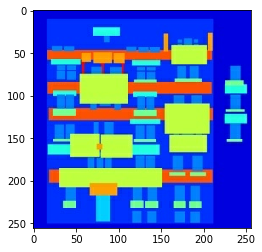

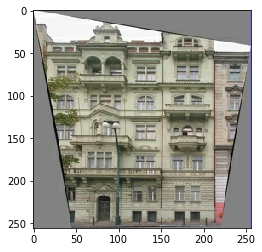

In [47]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.show()
plt.figure()
plt.imshow(re/255.0)
plt.show()

In [48]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [49]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]


In [50]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


In [51]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

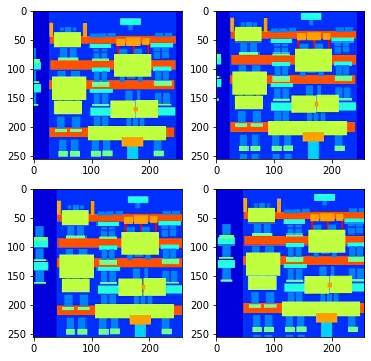

In [52]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('on')
plt.show()


In [53]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image



In [54]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image



In [55]:
"""## Input Pipeline"""

train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
# shuffling so that for every epoch a different image is generated
# to predict and display the progress of our model.
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

"""## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).
"""

'## Build the Generator\n  * The architecture of generator is a modified U-Net.\n  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)\n  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)\n  * There are skip connections between the encoder and decoder (as in U-Net).\n'

In [56]:
OUTPUT_CHANNELS = 3

In [57]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)



(1, 128, 128, 3)


In [58]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)



(1, 256, 256, 3)


In [59]:
"""Sub class the Generator as well."""
class Generator_(tf.keras.Model):
    """docstring for Generator_."""
    def __init__(self,):
        super(Generator_, self).__init__()
        self.downsample = [downsample(64, 4, apply_batchnorm=False),
                           downsample(128, 4),  # (bs, 64, 64, 128)
                           downsample(256, 4),  # (bs, 32, 32, 256)
                           downsample(512, 4),  # (bs, 16, 16, 512)
                           downsample(512, 4),  # (bs, 8, 8, 512)
                           downsample(512, 4),  # (bs, 4, 4, 512)
                           downsample(512, 4),  # (bs, 2, 2, 512)
                           downsample(512, 4)]  # (bs, 1, 1, 512)

        self.upsample = [upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
                         upsample(512, 4),  # (bs, 16, 16, 1024)
                         upsample(256, 4),  # (bs, 32, 32, 512)
                         upsample(128, 4),  # (bs, 64, 64, 256)
                         upsample(64, 4)]  # (bs, 128, 128, 128)

        initializer = tf.random_normal_initializer(0., 0.02)
        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                                    strides=2,
                                                    padding='same',
                                                    kernel_initializer=initializer,
                                                    activation='tanh') # (bs, 256, 256, 3)
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs, training=False):
        """Define the forward pass."""
        x = inputs
        # Downsampling through the model
        skips = []
        for down in self.downsample:
          x = down(x)
          skips.append(x)
        skips = reversed(skips[:-1])
        # Upsampling and establishing the skip connections
        for up, skip in zip(self.upsample, skips):
          x = up(x)
          x = self.concat([x, skip])
        return self.last(x)



generator = Generator_()

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])
plt.close()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


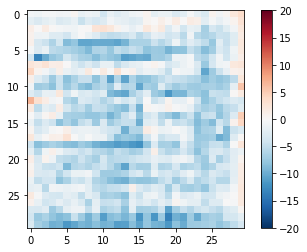

In [60]:
"""## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)
"""
"""
Build a class version of the discriminator here."""
class Discriminator_(tf.keras.Model):
    def __init__(self,):
        super(Discriminator_, self).__init__()
        """Define the layers used in the network."""
        initializer = tf.random_normal_initializer(0., 0.02)
        self.down1 = downsample(64, 4, False)
        self.down2 = downsample(128, 4)
        self.down3 = downsample(256, 4)
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                      kernel_initializer=initializer,
                                      use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU()
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                           kernel_initializer=initializer)

    def call(self, inputs, target, training=False):
        """Calculate the forward pass through the network."""
        x = tf.keras.layers.concatenate([inputs, target])
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.last(x)



discriminator = Discriminator_()
disc_out = discriminator(inp[tf.newaxis,...], gen_output, training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()



In [61]:
"""To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).
"""

LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# accuracy_object = tf.keras.metrics.categorical_accuracy()

In [62]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [63]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [64]:
"""## Checkpoints (Object-based saving)"""

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [65]:
"""## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* This entire procedure is shown in the images below.

![Discriminator Update Image](images/dis.png)


---


![Generator Update Image](images/gen.png)

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**
"""

EPOCHS = 200



In [66]:
def generate_images(model, test_input, tar, base_path='', epoch=0):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  """ Check the base path and make dir if needed."""
  if not os.path.exists(base_path):
    os.makedirs(base_path)

  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,8))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/result_{}.png'.format(epoch))
  plt.close()

In [67]:
@tf.function
def train_step(input_image, target, g_loss_metric, d_loss_metric):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator(input_image, target, training=True)
    disc_generated_output = discriminator(input_image, gen_output, training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Update the metrics
  g_loss_metric.update_state(gen_loss)
  d_loss_metric.update_state(disc_loss)
  # accuracy_metric.update_state(tf.ones_like(gen_output), gen_output)
  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

print("starting training")
def train(dataset, epochs):
  # Create the metrics
  g_loss_log = []
  d_loss_log = []
  g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
  d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')
  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  for epoch in range(epochs):
    start = time.time()
    # Reset the metrics
    g_loss_metric.reset_states()
    d_loss_metric.reset_states()
    counter = 0
    for input_image, target in dataset:
      train_step(input_image, target, g_loss_metric, d_loss_metric)
      counter += 1
      if counter > 100:
        break
    # Get the metric results
    g_mean_loss = g_loss_metric.result()
    d_mean_loss = d_loss_metric.result()
    g_loss_log.append([g_mean_loss])
    d_loss_log.append([d_mean_loss])
    # mean_accuracy = accuracy_metric.result()
    #
    print('Epoch: ', epoch)
    print('  loss (g) (d) (g+d):     {:.3f}, {:.3f}, {:.3f}'.format(g_mean_loss, d_mean_loss, g_mean_loss + d_mean_loss))

    if (epoch) % 10 == 0:
      for i, (inp, tar) in enumerate(test_dataset.take(5)):
        generate_images(generator, inp, tar, base_path='results/{}'.format(i), epoch=epoch)
        plot_losses(g_loss_log, d_loss_log, epoch=epoch, dataset='dataset')

    # saving (checkpoint) the model every 20 epochs
    # if (epoch + 1) % 20 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

starting training


In [35]:
train(train_dataset, EPOCHS)

Epoch:  0
  loss (g) (d) (g+d):     38.318, 0.615, 38.933
Time taken for epoch 1 is 29.143397092819214 sec

Epoch:  1
  loss (g) (d) (g+d):     37.771, 0.598, 38.370
Time taken for epoch 2 is 25.175634622573853 sec

Epoch:  2
  loss (g) (d) (g+d):     40.093, 0.642, 40.734
Time taken for epoch 3 is 24.920716047286987 sec

Epoch:  3
  loss (g) (d) (g+d):     38.823, 0.659, 39.483
Time taken for epoch 4 is 24.955049514770508 sec

Epoch:  4
  loss (g) (d) (g+d):     38.089, 0.679, 38.768
Time taken for epoch 5 is 25.101802825927734 sec

Epoch:  5
  loss (g) (d) (g+d):     37.536, 0.650, 38.185
Time taken for epoch 6 is 25.203922748565674 sec

Epoch:  6
  loss (g) (d) (g+d):     37.595, 0.664, 38.259
Time taken for epoch 7 is 25.192578554153442 sec

Epoch:  7
  loss (g) (d) (g+d):     38.216, 0.649, 38.865
Time taken for epoch 8 is 25.866470336914062 sec

Epoch:  8
  loss (g) (d) (g+d):     38.088, 0.635, 38.724
Time taken for epoch 9 is 25.242916107177734 sec

Epoch:  9
  loss (g) (d) (g+

In [36]:
"""## Restore the latest checkpoint and test"""

# restoring the latest checkpoint in checkpoint_dir

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [39]:
"""## Testing on the entire test dataset"""

# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
  generate_images(generator, inp, tar, base_path='results/0', epoch=EPOCHS)
